In [42]:
!pip install tensorflow

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\eesha\\appdata\\local\\programs\\python\\python39\\lib\\site-packages\\tensorflow-2.5.0.dist-info\\METADATA'



In [43]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
#from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [44]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'D:/cnn/dataset'
width=256
height=256
depth=3

In [45]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [46]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Bacterialblight ...
[INFO] Processing Blast ...
[INFO] Processing Brownspot ...
[INFO] Processing Tungro ...
[INFO] Image loading completed


In [47]:
image_size = len(image_list)
print(image_size)

800


In [48]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [49]:
print(label_binarizer.classes_)

['Bacterialblight' 'Blast' 'Brownspot' 'Tungro']


In [50]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [51]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [52]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [53]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 activation_14 (Activation)  (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_12 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 85, 85, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 85, 85, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 85, 85, 64)       

In [55]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


c:\users\eesha\appdata\local\programs\python\python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [56]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

C:\Users\eesha\AppData\Local\Temp/ipykernel_15196/1273247788.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/25
20/20 [==============================] - 69s 3s/step - loss: 0.7445 - accuracy: 0.6547 - val_loss: 0.9490 - val_accuracy: 0.2750
Epoch 2/25
20/20 [==============================] - 61s 3s/step - loss: 0.4783 - accuracy: 0.7281 - val_loss: 1.8596 - val_accuracy: 0.2313
Epoch 3/25
20/20 [==============================] - 53s 3s/step - loss: 0.4367 - accuracy: 0.7672 - val_loss: 2.5181 - val_accuracy: 0.2188
Epoch 4/25
20/20 [==============================] - 53s 3s/step - loss: 0.3490 - accuracy: 0.8078 - val_loss: 1.7944 - val_accuracy: 0.2688
Epoch 5/25
20/20 [==============================] - 55s 3s/step - loss: 0.3057 - accuracy: 0.8281 - val_loss: 1.8057 - val_accuracy: 0.2188
Epoch 6/25
20/20 [==============================] - 54s 3s/step - loss: 0.2673 - accuracy: 0.8469 - val_loss: 1.6538 - val_accuracy: 0.2812
Epoch 7/25
20/20 [==============================] - 53s 3s/step - loss: 0.2155 - accuracy: 0.8750 - val_loss: 1.4475 - val_accuracy: 0.2500
Epoch 8/25
20/20 [==

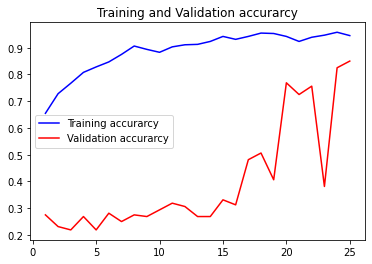

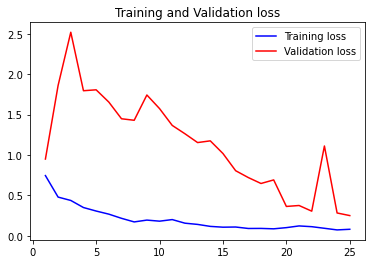

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [58]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
5/5 [==============================] - 2s 382ms/step - loss: 0.2495 - accuracy: 0.8500
Test Accuracy: 85.00000238418579


In [59]:
from sklearn.metrics import confusion_matrix
predictions=(model.predict(x_test)> 0.5).astype("int32")
confusion_matrix=confusion_matrix(np.asarray(y_test).argmax(axis=1),predictions.argmax(axis=1))

5/5 [==============================] - 2s 372ms/step


In [60]:
print(confusion_matrix)

[[30  5  2  0]
 [ 2 37  4  0]
 [ 2  7 26  0]
 [ 1  1  0 43]]


In [61]:
from sklearn.metrics import confusion_matrix

In [62]:
from sklearn.metrics import classification_report
pred = model.predict(x_test, batch_size = 32)
pred = np.argmax(pred, axis=1)
# label
y_target = np.argmax(y_test, axis=1)
y_target

5/5 [==============================] - 2s 429ms/step


array([3, 3, 0, 2, 0, 3, 1, 2, 3, 2, 0, 1, 3, 0, 1, 1, 1, 1, 3, 2, 3, 2,
       3, 3, 1, 0, 1, 3, 3, 2, 1, 0, 2, 1, 0, 0, 3, 1, 3, 3, 0, 1, 0, 1,
       2, 2, 2, 2, 3, 2, 1, 0, 3, 1, 1, 1, 2, 1, 0, 0, 2, 3, 3, 1, 1, 2,
       0, 3, 1, 0, 2, 0, 3, 0, 0, 0, 1, 2, 2, 2, 2, 0, 0, 0, 2, 3, 3, 1,
       1, 0, 3, 3, 1, 1, 3, 3, 3, 3, 0, 3, 0, 2, 0, 0, 0, 1, 1, 3, 1, 1,
       2, 2, 0, 0, 3, 0, 2, 3, 1, 1, 1, 1, 0, 3, 1, 1, 2, 0, 1, 3, 3, 1,
       0, 3, 1, 2, 3, 1, 3, 2, 1, 2, 2, 1, 0, 2, 0, 1, 3, 2, 3, 0, 3, 3,
       2, 2, 3, 3, 2, 3], dtype=int64)

In [63]:
print(classification_report(y_target, pred, target_names = label_binarizer.classes_))

                 precision    recall  f1-score   support

Bacterialblight       0.86      0.81      0.83        37
          Blast       0.74      0.86      0.80        43
      Brownspot       0.81      0.74      0.78        35
         Tungro       1.00      0.96      0.98        45

       accuracy                           0.85       160
      macro avg       0.85      0.84      0.85       160
   weighted avg       0.86      0.85      0.85       160

